#### Importing Modules

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import argparse
import math
import json
from pathlib import Path
from typing import Dict
from luhn import verify 

#### Basic Configuration

In [31]:
csv_path = "./data/cloudwalk_transactional-sample.csv"
output_dir = Path("./data/")
remap = {}
%matplotlib inline
matplotlib.rcParams.update({"figure.figsize": (9, 5),})

In [3]:
# Load dataset
df = pd.read_csv(csv_path)

#### Data Sanity Check

In [4]:
# Display information about the structure and data types of the checkout dataframes
print(df.shape, '\n')     # rows, columns
print(df.head(), '\n')    # quick look
print(df.info())    # datatypes, null counts

(3199, 8) 

   transaction_id  merchant_id  user_id       card_number  \
0        21320398        29744    97051  434505******9116   
1        21320399        92895     2708  444456******4210   
2        21320400        47759    14777  425850******7024   
3        21320401        68657    69758  464296******3991   
4        21320402        54075    64367  650487******6116   

             transaction_date  transaction_amount  device_id  has_cbk  
0  2019-12-01T23:16:32.812632              374.56   285475.0    False  
1  2019-12-01T22:45:37.873639              734.87   497105.0     True  
2  2019-12-01T22:22:43.021495              760.36        NaN    False  
3  2019-12-01T21:59:19.797129             2556.13        NaN     True  
4  2019-12-01T21:30:53.347051               55.36   860232.0    False   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              -------

That device id column has 830 number of missing values, and 2369 non-null, meaning around 26% null. <br>
We'll later decide whether to impute, drop, or treat as a suspicious signal.



#### Normalize Data
- Check if has_cbk is really a boolean, and if not, normalize it
- Parse datetime transaction date column from string format to a proper time format
- Create a boolean column checking if the transaction value is equal or above 50.000 (True), or below it (False)
- Create a boolean column checking if the transaction was done at night (True), between 10 p.m. and 6 a.m, or day (False)

In [ ]:
# Check has_cbk
print(df["has_cbk"].unique())

# Parse datetime column safely
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')

# Transaction values as booleans: high-value transaction (>= 50,000)
df['is_high_value'] = df['transaction_amount'] >= 50_000

# Day periods as boolean: night transaction (22:00 – 06:00)
df['is_night'] = df['transaction_date'].dt.hour.isin(list(range(22, 24)) + list(range(0, 6)))

# Inspect work done
print(df[['transaction_date', 'transaction_amount', 'is_high_value', 'is_night']].head())

# Calculate the counted percentage of transactions that is a chargeback
cbk_rate = df["has_cbk"].mean() * 100
print(f"Chargeback percentage: {cbk_rate:.2f}%")

[False  True]
               transaction_date  transaction_amount  is_high_value  is_night
3198 2019-11-01 01:27:15.811098             2416.70          False      True
3197 2019-11-01 01:29:45.799767              359.68          False      True
3196 2019-11-01 10:23:50.555604                1.55          False     False
3195 2019-11-01 11:47:02.404963             1403.67          False     False
3194 2019-11-01 13:05:34.054967              744.15          False     False
Chargeback percentage: 12.22%


#### Further Data Sanity Checks
- Check in min/max dates if we can find unliquely data, like 'future' or 'ancient' transactions, or duplicated datetimes with same ids<br>
- Verify if all transaction amounts are above 0<br>
- Ensure that transaction id is unique<br>

In [10]:
# Quick date sanity: min/max, future, duplicated (same id + same datetime)
print("Min date:", df['transaction_date'].min())
print("Max date:", df['transaction_date'].max())

# Find transactions later than now to flag "future" transactions
# Using 'naive' timezones to avoid comparison conflicts
now_naive = pd.Timestamp.utcnow().tz_localize(None)
future_mask = df['transaction_date'] > now_naive
dup_pair_mask = df.duplicated(subset=['transaction_id','transaction_date'], keep=False)
print("Future tx count:", future_mask.sum())
print("Duplicated (same id & same datetime) count:", dup_pair_mask.sum())
print("Invalid/NaT datetimes:", df['transaction_date'].isna().sum())

# Amounts > 0
nonpos_mask = df['transaction_amount'] <= 0
print("Non-positive amounts (<=0):", nonpos_mask.sum())

# Uniqueness of transaction_id
print("Is transaction_id unique?", df['transaction_id'].is_unique)

Min date: 2019-11-01 01:27:15.811098
Max date: 2019-12-01 23:16:32.812632
Future tx count: 0
Duplicated (same id & same datetime) count: 0
Invalid/NaT datetimes: 0
Non-positive amounts (<=0): 0
Is transaction_id unique? True


#### Transaction Times
- Find the likely transaction time of users and devices<br>
- Multiple transactions in the same second by same user_id or device_id<br>
- Transaction_date: boxplot sobre os diferentes ids

Median user time between transactions: 0 days 02:25:47.011072
Median device time between transactions: 0 days 01:53:41.230429
Users with single transaction: 2469
Devices with single transaction: 1819
Max transactions per user per second: 1


<Figure size 800x600 with 0 Axes>

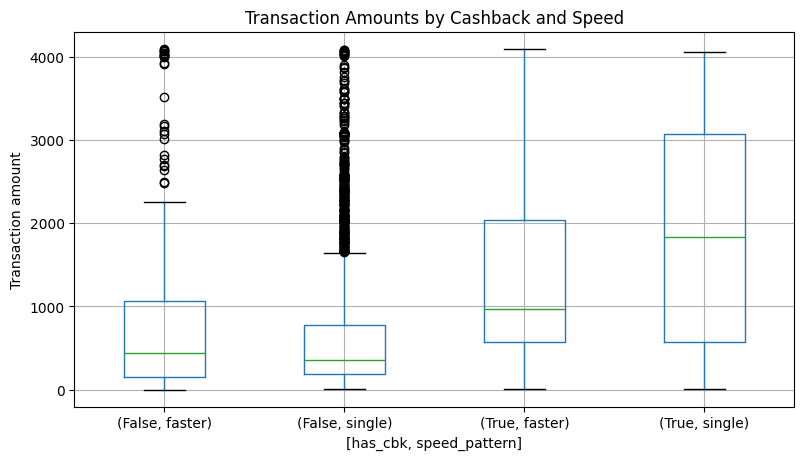

In [27]:
# Median time between transactions
def median_diff(group):
    if len(group) <= 1:
        return pd.NaT
    return group.sort_values().diff().median()

median_user = df.groupby('user_id')['transaction_date'].apply(median_diff).dropna()
median_device = df.groupby('device_id')['transaction_date'].apply(median_diff).dropna()

print("Median user time between transactions:", median_user.median())
print("Median device time between transactions:", median_device.median())

# Count of single transactions
user_counts = df['user_id'].value_counts()
device_counts = df['device_id'].value_counts()
print("Users with single transaction:", (user_counts == 1).sum())
print("Devices with single transaction:", (device_counts == 1).sum())

# Transactions in the same second by user or device
df['tx_second'] = df['transaction_date'].dt.floor('s')
dupes_user = df[df.duplicated(subset=['user_id','tx_second'], keep=False)]
dupes_device = df[df.duplicated(subset=['device_id','tx_second'], keep=False)]

print("Max transactions per user per second:", df.groupby(['user_id','tx_second']).size().max())

# Boxplots (cashback vs. transaction speed patterns)
# Add flags
df['user_median'] = df['user_id'].map(median_user)
df['time_diff'] = df.groupby('user_id')['transaction_date'].diff()
df['faster_than_median'] = df['time_diff'] < df['user_median']
df['single_tx'] = df['user_id'].map(user_counts) == 1

# Ensure categories for plotting
df['speed_pattern'] = pd.NA
df.loc[df['single_tx'], 'speed_pattern'] = 'single'
df.loc[df['faster_than_median'] == True, 'speed_pattern'] = 'faster'

plt.figure(figsize=(8,6))
df.boxplot(column='transaction_amount', by=['has_cbk','speed_pattern'])
plt.title("Transaction Amounts by Cashback and Speed")
plt.suptitle("")
plt.ylabel("Transaction amount")
plt.show()

#### Temporal Patterns

Check curves for daily cashbacks and transactions, as well as odd-hour concentrations.

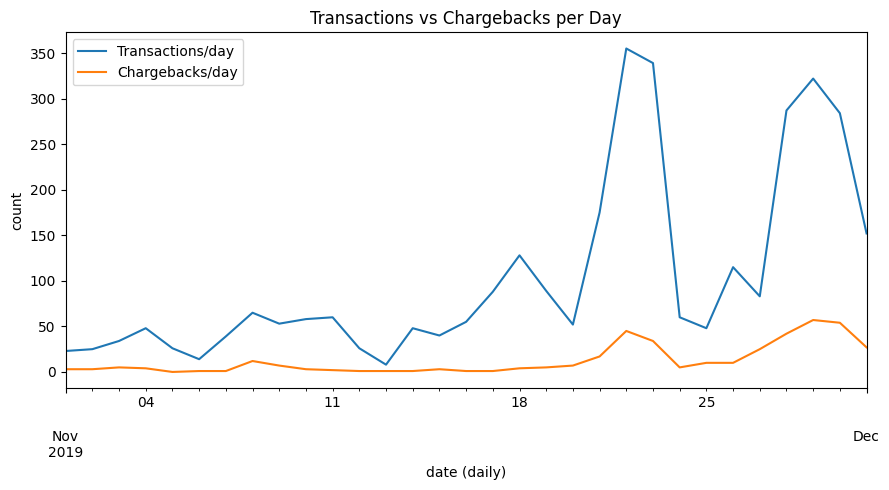

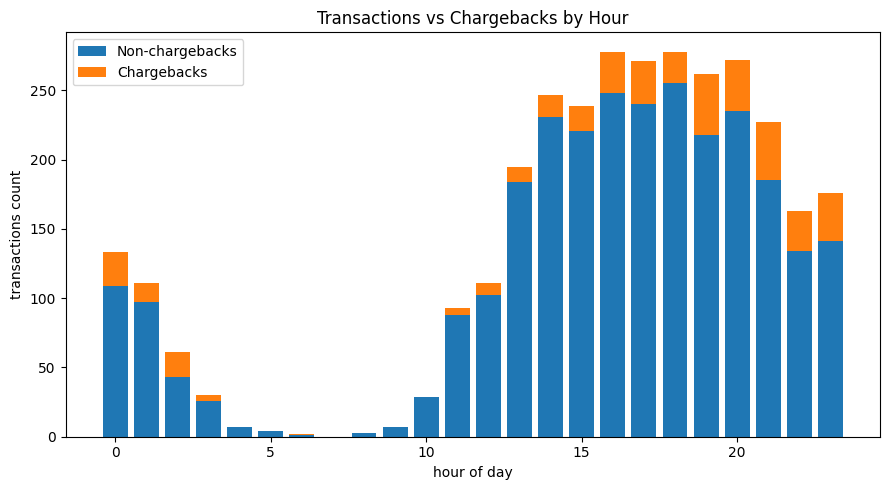

In [39]:
df = df.sort_values("transaction_date").copy()
s = df.set_index("transaction_date")

daily = s.resample("D").agg(txn=("transaction_id","count"), 
                            cbk=("has_cbk","sum"))
daily["cbk_mean7"] = daily["cbk"].rolling(7, min_periods=3).mean()
daily["cbk_std7"]  = daily["cbk"].rolling(7, min_periods=3).std()
daily["cbk_spike"] = daily["cbk"] > (daily["cbk_mean7"] + 2*daily["cbk_std7"])

daily.to_csv(output_dir / "timeseries_daily_txn_cbk.csv")

plt.figure()
daily["txn"].plot(label="Transactions/day")
daily["cbk"].plot(label="Chargebacks/day")

plt.xlabel("date (daily)")
plt.ylabel("count")
plt.title("Transactions vs Chargebacks per Day")
plt.legend()
plt.tight_layout()
plt.savefig(output_dir / "chart_timeseries_daily_txn_cbk_overlay.png", dpi=150)
plt.show()

tx_per_hour = df.groupby("hour")["transaction_id"].count()
cbk_per_hour = df.groupby("hour")["has_cbk"].sum()
non_cbk_per_hour = tx_per_hour - cbk_per_hour

# Stacked bar plot
plt.figure()
plt.bar(tx_per_hour.index, non_cbk_per_hour, label="Non-chargebacks", color="C0")
plt.bar(cbk_per_hour.index, cbk_per_hour, bottom=non_cbk_per_hour, label="Chargebacks", color="C1")

plt.xlabel("hour of day")
plt.ylabel("transactions count")
plt.title("Transactions vs Chargebacks by Hour")
plt.legend()
plt.tight_layout()
plt.savefig(output_dir / "chart_hour_of_day_txn_cbk_stacked.png", dpi=150)
plt.show()


#### Amount Distribution: Chargeback vs Normal
**Purpose:** Compare `transaction_amount` distributions.  
**Look for:** skew toward large/small values, heaping around round numbers, merchant-specific anomalies.


<Figure size 900x500 with 0 Axes>

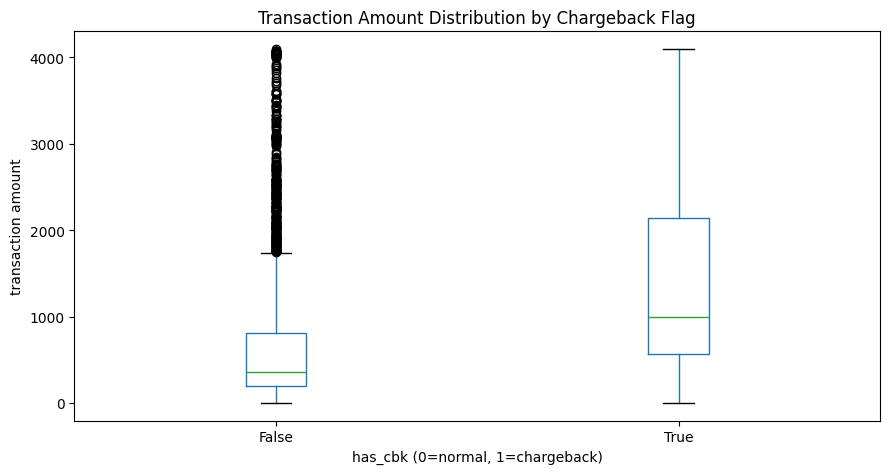

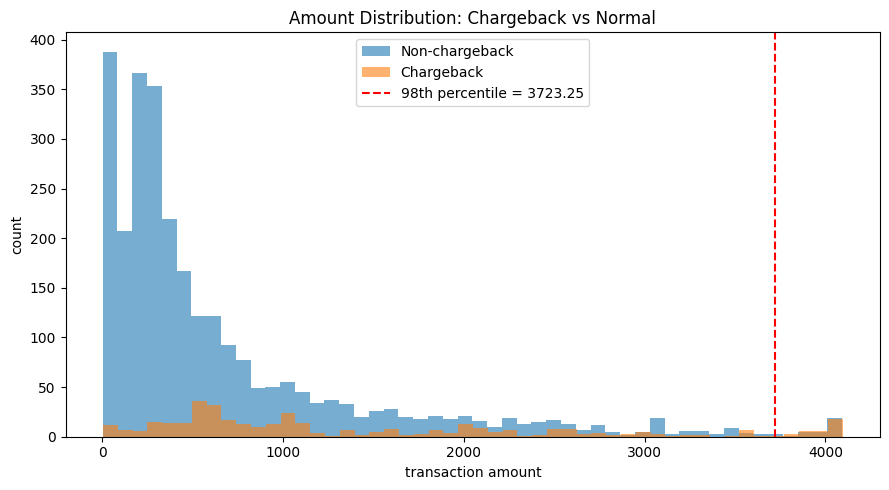

Transactions above 98th percentile: 31
      transaction_id  transaction_amount
3173        21323571             4044.35
3167        21323565             4054.06
3165        21323563             4031.00
3157        21323555             4028.55
3144        21323542             4026.57


In [57]:
# Split chargeback vs non-chargeback
cbk_amounts = df.loc[df["has_cbk"] == 1, "transaction_amount"]
non_cbk_amounts = df.loc[df["has_cbk"] == 0, "transaction_amount"]

# Boxplot for clearer comparison
plt.figure()
df.boxplot(column="transaction_amount", by="has_cbk", grid=False)
plt.xlabel("has_cbk (0=normal, 1=chargeback)")
plt.ylabel("transaction amount")
plt.title("Transaction Amount Distribution by Chargeback Flag")
plt.suptitle("")
plt.tight_layout()
plt.savefig(output_dir / "chart_boxplot_amount_cbk_vs_normal.png", dpi=150)
plt.show()

# Overlad histogram
p98 = np.percentile(df["transaction_amount"], 98)
plt.figure()
plt.hist(non_cbk_amounts, bins=50, alpha=0.6, label="Non-chargeback", color="C0")
plt.hist(cbk_amounts, bins=50, alpha=0.6, label="Chargeback", color="C1")
plt.axvline(p98, color="red", linestyle="--", label=f"98th percentile = {p98:.2f}")
plt.xlabel("transaction amount")
plt.ylabel("count")
plt.title("Amount Distribution: Chargeback vs Normal")
plt.legend()
plt.tight_layout()
plt.savefig(output_dir / "chart_amount_distribution_cbk_vs_normal.png", dpi=150)
plt.show()

# Transactions with high amounts
h_amount = df[df["transaction_amount"] > p98]
print(f"Transactions above 98th percentile: {len(outliers)}")
print(h_amount[["transaction_id", "transaction_amount"]].head())


 #### Device Check
 - Check if missing device ids correlates with higher chargeback rates<br>
 - Check if some user id to device id combos appear too often, indicating possible fraud rings

In [62]:
# Missing device_id vs chargeback rate
missing_cbk_rate = df[df["device_id"].isna()]["has_cbk"].mean() * 100
present_cbk_rate = df[df["device_id"].notna()]["has_cbk"].mean() * 100
print(f"Chargeback % (missing device_id): {missing_cbk_rate:.2f}%")
print(f"Chargeback % (with device_id):   {present_cbk_rate:.2f}%")

# User–Device combos (potential fraud rings)
combo_counts = df.groupby(["user_id", "device_id"]).size().reset_index(name="txn_count")

# Find combos that appear unusually often
suspicious_combos = combo_counts[combo_counts["txn_count"] > combo_counts["txn_count"].quantile(0.98)]

# Add chargeback percentage
cbk_ratio = (df.groupby(["user_id", "device_id"])["has_cbk"].mean()
             .reset_index(name="cbk_ratio"))

suspicious_combos = suspicious_combos.merge(cbk_ratio,
                                            on=["user_id", "device_id"], how="left")
suspicious_combos["cbk_pct"] = suspicious_combos["cbk_ratio"] * 100

print("Suspicious user–device combos (top 1% by txn_count):")
print(suspicious_combos.sort_values("txn_count", ascending=False)
      .head(20)[["user_id","device_id","txn_count","cbk_pct"]])

Chargeback % (missing device_id): 8.07%
Chargeback % (with device_id):   13.68%
Suspicious user–device combos (top 1% by txn_count):
    user_id  device_id  txn_count     cbk_pct
35    91637   563499.0         22   86.363636
8     11750   342890.0         19   78.947368
30    79054   101848.0         17   88.235294
36    96025   438940.0         14   92.857143
29    78262   547440.0         13   92.307692
7     11452   274282.0          8   37.500000
2      7695   223682.0          7   57.142857
9     11750   542535.0          7   85.714286
28    77959   589318.0          7    0.000000
14    21768   357277.0          6  100.000000
32    83722   978084.0          6   66.666667
24    67519   262327.0          6   66.666667
0      3584   707086.0          6   66.666667
13    17929   960729.0          6  100.000000
23    67245   115003.0          5    0.000000
3      7725   308950.0          5  100.000000
4      9853   686249.0          5   80.000000
25    69588   766158.0          5   80.

 #### Merchant Check
 - Merchants with high percentage of chargeback per transaction

In [67]:
# Merchants with lots of chargebacks (>20%)
m_stats = df.groupby("merchant_id")["has_cbk"].agg(cbk_ratio="mean", txn_count="count")
hi_cbk_merchants = m_stats.query("cbk_ratio > 0.20").sort_values(["cbk_ratio","txn_count"], ascending=False)

print("High-CBK merchants (>20%):")
print(hi_cbk_merchants.head(20))

High-CBK merchants (>20%):
             cbk_ratio  txn_count
merchant_id                      
1308               1.0         15
44927              1.0         11
73271              1.0         10
38337              1.0          6
48126              1.0          6
75917              1.0          6
81795              1.0          6
8942               1.0          5
15326              1.0          5
38568              1.0          5
89943              1.0          5
25932              1.0          4
72723              1.0          4
41354              1.0          3
52897              1.0          3
54603              1.0          3
59875              1.0          3
65241              1.0          3
73205              1.0          3
3531               1.0          2


 #### 14 - User Check
 - Muitos chargebacks pequenos do mesmo id<br>
 - Pessoa jurídica tem muita fraude, principalmente por gerentes de agência

In [78]:
# user-level stats
user_stats = df.groupby("user_id")["has_cbk"].agg(cbk_ratio="mean", txn_count="count")

# users with 100% chargebacks
full_cbk_users = user_stats[user_stats["cbk_ratio"] == 1.0]
high_cbk_users = user_stats[user_stats["cbk_ratio"] >= 0.2]

print(f"Users with 100% chargeback ratio: {len(full_cbk_users)}")
print(f"Users with more than 20% chargeback ratio: {len(high_cbk_users)}")

Users with 100% chargeback ratio: 120
Users with more than 20% chargeback ratio: 153


 #### 15 - Device Check
 - muitos chargebacks pequenos do mesmo id<br>
 - device_id: muitos por merchant<br>
 - valores grandes em um device_id nunca visto antes

#### 16 - Card Check
 - muitos chargebacks pequenos do mesmo id<br>
 - card_number: vários por usuário<br>
 - cartão emitido recentemente<br>
 - cartão online tem mais chances do que físico

#### 17 - Reuse & Linkage (Devices/Cards/Users)
**Purpose:** Spot cross-linkage suggesting synthetic identities or mule devices.  
**Look for:** devices used by many users/cards; cards used across users; overlap with cbk.

In [ ]:
reuse_dev_users = df.groupby("device_id")["user_id"].nunique().sort_values(ascending=False)
reuse_dev_cards = df.groupby("device_id")["card_number"].nunique().sort_values(ascending=False)
reuse_card_users = df.groupby("card_number")["user_id"].nunique().sort_values(ascending=False)
reuse_user_cards = df.groupby("user_id")["card_number"].nunique().sort_values(ascending=False)

reuse_df = pd.DataFrame({
    "users_per_device": reuse_dev_users,
    "cards_per_device": reuse_dev_cards
}).fillna(0).astype(int)
reuse_df.to_csv(outdir / "reuse_by_device.csv")

suspicious_devices = reuse_df[(reuse_df["users_per_device"] >= 3) | (reuse_df["cards_per_device"] >= 3)]
suspicious_devices.to_csv(outdir / "suspicious_devices.csv")

plt.figure(); top_n(reuse_dev_users, 20).plot(kind="bar")
plt.xlabel("device_id"); plt.ylabel("# unique users")
safe_savefig(outdir / "chart_top_devices_users.png", "Devices used by many users")

plt.figure(); top_n(reuse_card_users, 20).plot(kind="bar")
plt.xlabel("card_number"); plt.ylabel("# unique users")
safe_savefig(outdir / "chart_top_cards_users.png", "Cards used by many users")

suspicious_devices.head(10)


#### 18 - Threshold & Heaping in Amounts
**Purpose:** Detect “threshold splitting” and round-number heaping.  
**Look for:** spikes just below round thresholds; elevated cbk in specific amount bands.


In [ ]:
df["amt_mod_10"] = (df["transaction_amount"] % 10).round(2)
df["amt_mod_100"] = (df["transaction_amount"] % 100).round(2)

plt.figure(); df["amt_mod_10"].plot(kind="hist", bins=50, alpha=0.8)
plt.xlabel("amount mod 10"); plt.ylabel("count")
safe_savefig(outdir / "chart_amount_mod10_hist.png", "Heaping check: amount mod 10")

df["amount_q"] = pd.qcut(df["transaction_amount"].rank(method="first"), 50, duplicates="drop")
cbk_by_q = df.groupby("amount_q")["has_cbk"].mean()
plt.figure(); cbk_by_q.reset_index(drop=True).plot()
plt.xlabel("amount quantile bins"); plt.ylabel("chargeback rate")
safe_savefig(outdir / "chart_cbk_rate_by_amount_quantile.png", "Chargeback rate across amount quantiles")

cbk_by_q.tail()


#### 20 - User × Merchant Chargeback Heatmap
**Purpose:** Visualize cbk frequency across user × merchant pairs, highliting specially those with more than 20% chargeback incidence.<br>
**Look for:** dense rows/columns (rings of abuse).


In [ ]:

pivot = (df.groupby(["user_id","merchant_id"])["has_cbk"].mean().unstack(fill_value=0))

top_users = df["user_id"].value_counts().head(30).index
top_merch = df["merchant_id"].value_counts().head(30).index
sub = pivot.loc[pivot.index.intersection(top_users), pivot.columns.intersection(top_merch)]

if sub.empty:
    print("Heatmap skipped (not enough overlap for top users/merchants).")
else:
    plt.figure()
    plt.imshow(sub.values, aspect="auto", interpolation="nearest")
    plt.xlabel("merchant_id (top)"); plt.ylabel("user_id (top)")
    cbar = plt.colorbar(); cbar.set_label("cbk rate")
    safe_savefig(outdir / "chart_heatmap_user_merchant_cbk.png", "Heatmap: user × merchant cbk rate")

sub.head()


#### 21 - Network-Style Linkage (Edge Lists)
**Purpose:** Export edges to inspect linkage with degree-rank plot <br>
**Look for:** hubs (devices/cards) linking many users with cbk history.


In [ ]:
outdir = Path("out"); outdir.mkdir(exist_ok=True)

# 1) Clean edges (drop NaNs, cast to str to avoid 123.0 labels)
edges = {
    "user_device": (
        df[["user_id","device_id"]]
        .dropna()
        .astype({"user_id": "int64", "device_id": "int64"})
        .astype(str)
        .drop_duplicates()
    ),
    "user_card": (
        df[["user_id","card_number"]]
        .dropna()
        .astype({"user_id": "int64"})
        .astype(str)
        .drop_duplicates()
    ),
    "user_merchant": (
        df[["user_id","merchant_id"]]
        .dropna()
        .astype({"user_id": "int64", "merchant_id": "int64"})
        .astype(str)
        .drop_duplicates()
    ),
}

# 2) Build graph
G = nx.Graph()
for r in edges["user_device"].itertuples(index=False):
    G.add_edge(f"user:{r.user_id}", f"device:{r.device_id}")
for r in edges["user_card"].itertuples(index=False):
    G.add_edge(f"user:{r.user_id}", f"card:{r.card_number}")
for r in edges["user_merchant"].itertuples(index=False):
    G.add_edge(f"user:{r.user_id}", f"merchant:{r.merchant_id}")

print(f"nodes={G.number_of_nodes()}, edges={G.number_of_edges()}")

# 3) Degree rank plot (only if we have data)
if G.number_of_edges() > 0:
    deg = pd.Series(dict(G.degree()), dtype="int64").sort_values(ascending=False)
    if not deg.empty:
        fig = plt.figure()
        plt.plot(np.arange(len(deg)), deg.to_numpy(), marker=".", linewidth=1)
        plt.xlabel("node rank"); plt.ylabel("degree"); plt.title("Network node degree rank")
        plt.tight_layout()
        plt.savefig(outdir / "chart_network_degree_rank.png", dpi=150)
        plt.close(fig)
    else:
        print("No degrees to plot (deg is empty).")
else:
    print("Graph has zero edges — check NaNs/dtypes and edge builders.")

# assuming G is already built
plt.figure(figsize=(12, 12))

# Choose a layout (spring layout is good for medium-size graphs)
pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=20, node_color="skyblue", alpha=0.7)
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.4)
# Optionally add labels for a few top-degree nodes
top_nodes = [n for n, d in sorted(G.degree, key=lambda x: -x[1])[:10]]
nx.draw_networkx_labels(G, pos, labels={n: n for n in top_nodes}, font_size=8)

plt.axis("off")
plt.title("User–Device–Card–Merchant Network")
plt.tight_layout()
plt.savefig(outdir / "chart_network.png", dpi=200)
plt.show()

 #### Other possible analysis:
 - Number of cards per user<br>
 - Number of transactions per user<br>
 - Many failed attempts <br>
 - Abnormal locations <br><br>